![](https://i.postimg.cc/3JB8XVND/Screenshot-2025-07-10-111527.png)

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Importing Libraries</span>


In [1]:
#  Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Loading The Data</span>


In [2]:
#  Load data
df = pd.read_csv('/kaggle/input/stock-trading-app-reviews-zerodha-groww-etc/Stock_Trading_App_Reviews.csv')  # replace with actual path

In [3]:
df.head()

,reviewId,content,score,app
0,be071c83-6d3c-4db3-94c0-2714c04fc47d,good app,4,Zerodha (Kite)
1,aedd0c3c-69ef-4088-813f-df473e00ef0f,good,5,Zerodha (Kite)
2,994812ae-8110-47e4-9e8f-6dba21dc37f8,nice app better than angelone in terms of brok...,5,Zerodha (Kite)
3,e15872b4-b646-4878-b35e-d26527379bec,good,5,Zerodha (Kite)
4,20237158-d654-4796-84c4-e809c7034de7,happy with customer service,5,Zerodha (Kite)


In [4]:
df.isnull().sum()

reviewId    0
content     2
score       0
app         0
dtype: int64

In [5]:
df.dropna(subset=['content'], inplace=True)

In [6]:
df.isnull().sum()

reviewId    0
content     0
score       0
app         0
dtype: int64

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Preprocessing</span>


In [7]:
#  Preprocessing: Create sentiment label
df['sentiment'] = df['score'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))


In [8]:
df.head()

,reviewId,content,score,app,sentiment
0,be071c83-6d3c-4db3-94c0-2714c04fc47d,good app,4,Zerodha (Kite),positive
1,aedd0c3c-69ef-4088-813f-df473e00ef0f,good,5,Zerodha (Kite),positive
2,994812ae-8110-47e4-9e8f-6dba21dc37f8,nice app better than angelone in terms of brok...,5,Zerodha (Kite),positive
3,e15872b4-b646-4878-b35e-d26527379bec,good,5,Zerodha (Kite),positive
4,20237158-d654-4796-84c4-e809c7034de7,happy with customer service,5,Zerodha (Kite),positive


<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">EDA</span>


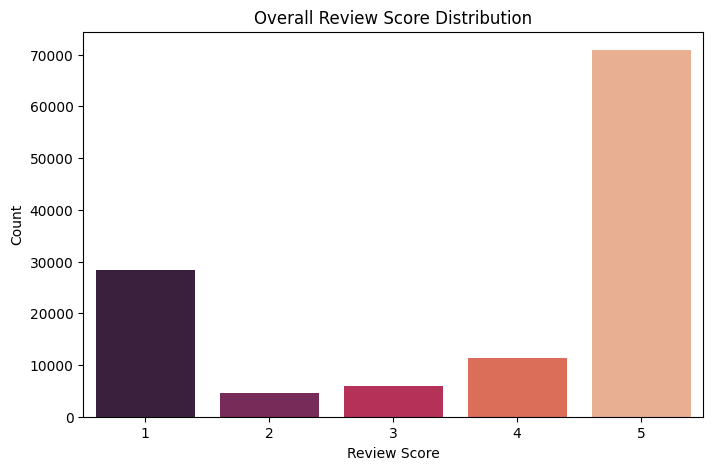

In [9]:
#  1. Distribution of review scores (1 to 5 stars)
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='score', palette='rocket')
plt.title("Overall Review Score Distribution")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

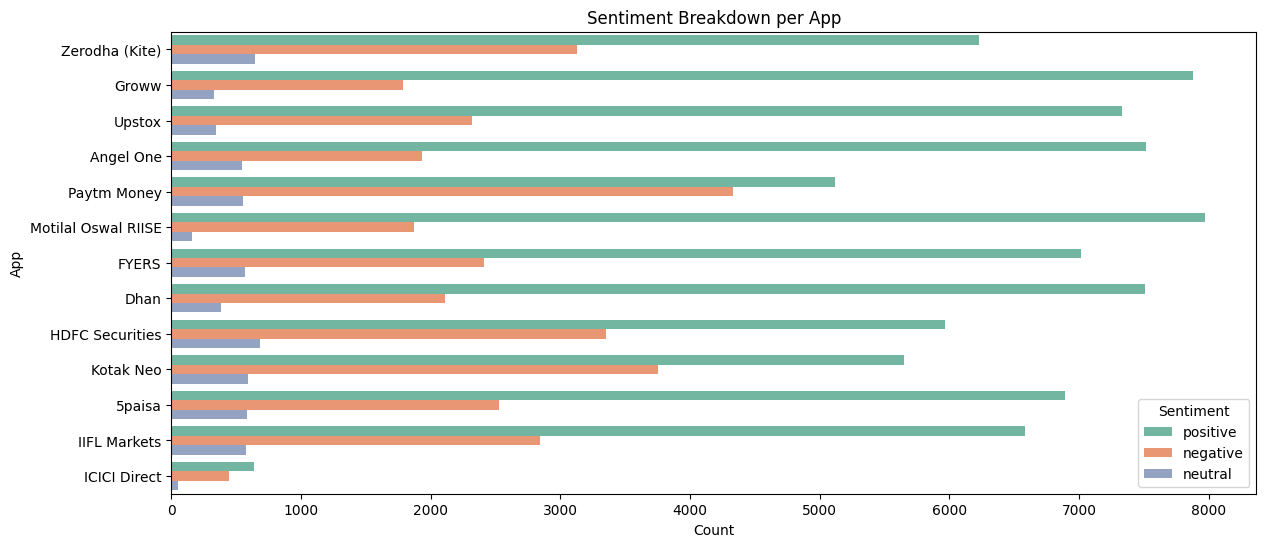

In [10]:
#  2. Sentiment count per app
plt.figure(figsize=(14,6))
sns.countplot(data=df, y='app', hue='sentiment', order=df['app'].value_counts().index, palette='Set2')
plt.title("Sentiment Breakdown per App")
plt.xlabel("Count")
plt.ylabel("App")
plt.legend(title='Sentiment')
plt.show()


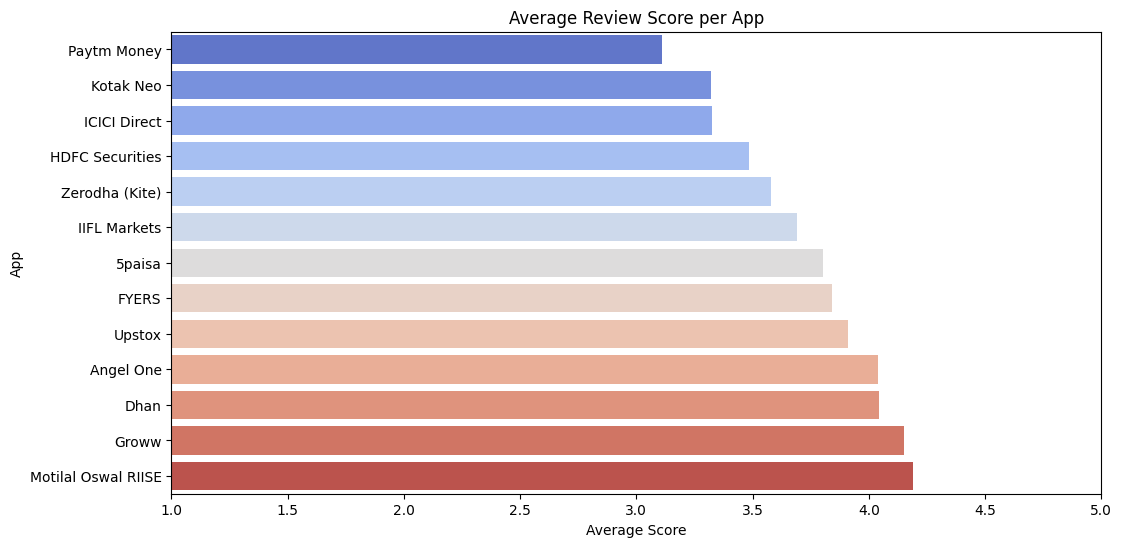

In [11]:
#  3. Average score per app
avg_scores = df.groupby("app")["score"].mean().sort_values()
plt.figure(figsize=(12,6))
sns.barplot(x=avg_scores.values, y=avg_scores.index, palette="coolwarm")
plt.title("Average Review Score per App")
plt.xlabel("Average Score")
plt.ylabel("App")
plt.xlim(1, 5)
plt.show()

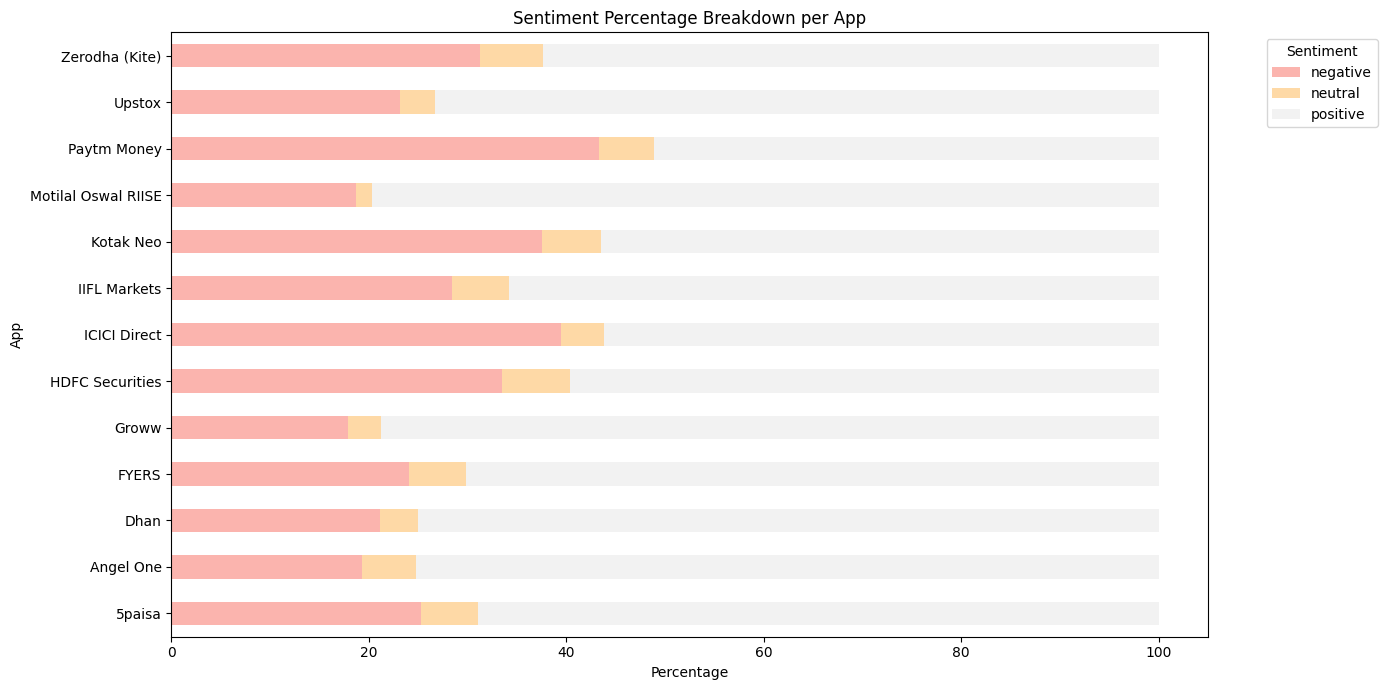

In [12]:
#  4. Sentiment ratio per app
sentiment_ratio = df.groupby(['app', 'sentiment']).size().unstack().fillna(0)
sentiment_percent = sentiment_ratio.div(sentiment_ratio.sum(axis=1), axis=0) * 100

sentiment_percent.plot(kind='barh', stacked=True, figsize=(14,7), colormap='Pastel1')
plt.title("Sentiment Percentage Breakdown per App")
plt.xlabel("Percentage")
plt.ylabel("App")
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

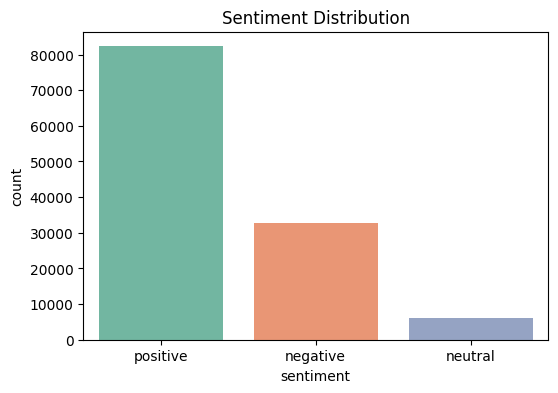

In [13]:
#  5: Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.show()

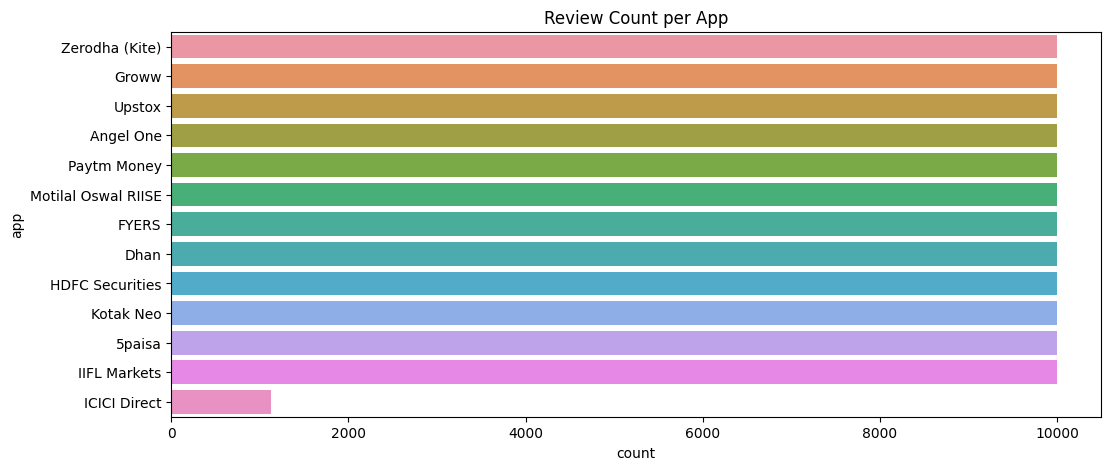

In [15]:
#  6: Distribution of reviews per app
plt.figure(figsize=(12,5))
sns.countplot(data=df, y='app', order=df['app'].value_counts().index)
plt.title("Review Count per App")
plt.show()

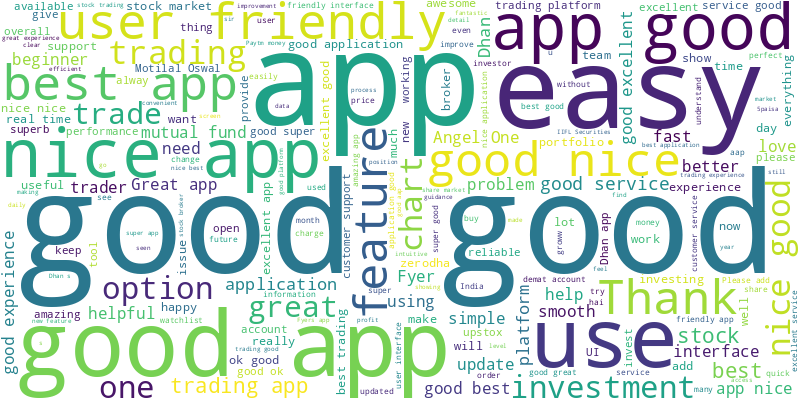

In [16]:
# 7: WordCloud for Positive Reviews
pos_text = " ".join(df[df.sentiment == 'positive']['content'].dropna())
WordCloud(width=800, height=400, background_color='white').generate(pos_text).to_image()

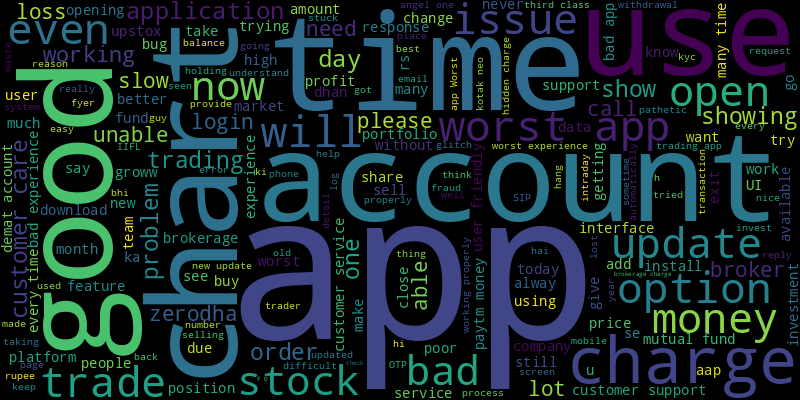

In [17]:
# 8: WordCloud for Negative Reviews
neg_text = " ".join(df[df.sentiment == 'negative']['content'].dropna())
WordCloud(width=800, height=400, background_color='black').generate(neg_text).to_image()

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Dividing The Data In X and Y</span>


In [18]:
#  Modeling: Simple Sentiment Classifier
df = df[df['sentiment'] != 'neutral']  # Drop neutral for binary classification
X = df['content']
y = df['sentiment'].map({'positive': 1, 'negative': 0})

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Vectorizing</span>


In [19]:
# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vec = vectorizer.fit_transform(X)

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Train Test Split</span>


In [20]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Logisitic Regression</span>


In [21]:
# Model
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      6546
           1       0.93      0.96      0.94     16476

    accuracy                           0.92     23022
   macro avg       0.91      0.89      0.90     23022
weighted avg       0.92      0.92      0.92     23022



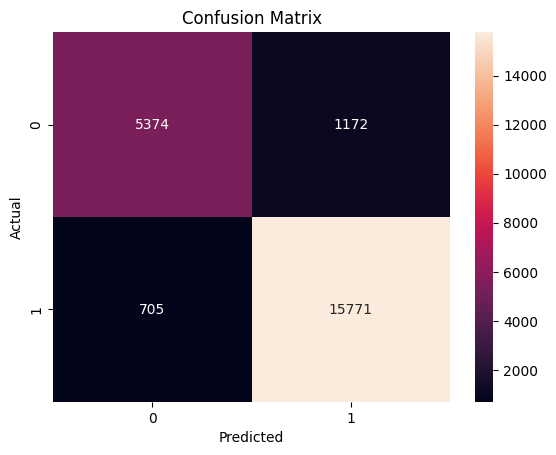

In [22]:
# Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">SVC</span>


 Linear SVM
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      6546
           1       0.93      0.96      0.94     16476

    accuracy                           0.92     23022
   macro avg       0.90      0.89      0.89     23022
weighted avg       0.92      0.92      0.92     23022



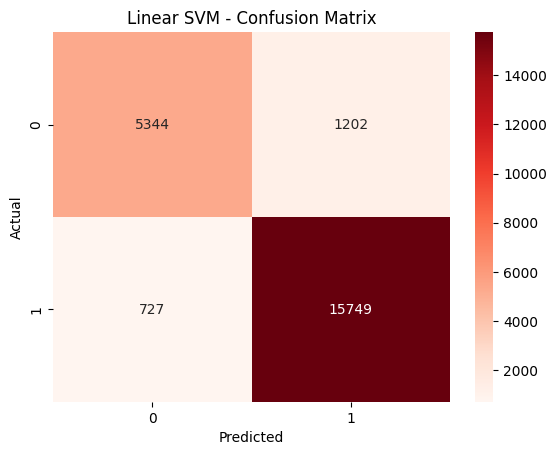

In [25]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(" Linear SVM\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Linear SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">XGBoost</span>


 XGBoost
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      6546
           1       0.91      0.97      0.94     16476

    accuracy                           0.91     23022
   macro avg       0.90      0.86      0.88     23022
weighted avg       0.91      0.91      0.90     23022



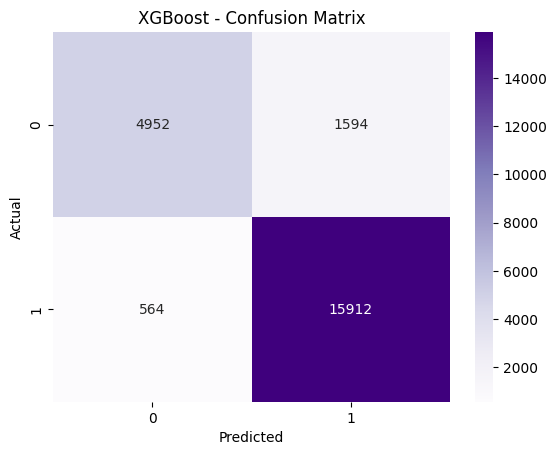

In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(" XGBoost\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">RandomForestClassifier</span>


 Random Forest
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      6546
           1       0.94      0.94      0.94     16476

    accuracy                           0.91     23022
   macro avg       0.90      0.89      0.89     23022
weighted avg       0.91      0.91      0.91     23022



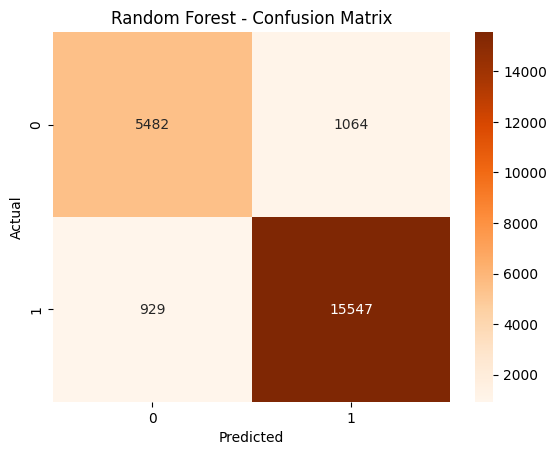

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(" Random Forest\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Smash That Upvote !! Thanks ! 🚀😃</span>
